In [4]:
# Librerías básicas de Python
import numpy as np
import pandas as pd
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# XGBoost
import xgboost as xgb

# Visualización
import matplotlib.pyplot as plt

# Serialización de modelos (opcional, solo para .pkl)
import joblib

print("✓ Todas las librerías importadas correctamente")
print(f"Versión pandas: {pd.__version__}")
print(f"Versión numpy: {np.__version__}")
print(f"Versión xgboost: {xgb.__version__}")

inicio_proceso = datetime.now()
print("="*80)
print(f"FECHA Y HORA DE INICIO: {inicio_proceso.strftime('%Y-%m-%d %H:%M:%S')}")

✓ Todas las librerías importadas correctamente
Versión pandas: 2.0.3
Versión numpy: 1.24.3
Versión xgboost: 3.0.5
FECHA Y HORA DE INICIO: 2025-12-09 16:53:21



SISTEMA DE PREDICCIÓN - NUEVOS COMPUESTOS

1. Cargando modelo y metadatos...
   ✓ Modelo cargado exitosamente
   ✓ Fecha entrenamiento: 20251209_164939
   ✓ RMSE Test: 0.6013
   ✓ R² Test: 0.6600

2. Cargando nuevos compuestos...
   ✓ 8575 compuestos cargados
Tamaño del dataset con descriptores de Drugbank: (8575, 215)

3. Preparando datos...
   ✓ Matriz de predictores ordenados: (8575, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8575 entries, 0 to 8574
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NumN                      8575 non-null   int64  
 1   NumHDonors                8575 non-null   int64  
 2   MinEStateIndex            8575 non-null   float64
 3   FpDensityMorgan2          8575 non-null   float64
 4   FpDensityMorgan3          8575 non-null   float64
 5   BCUT2D_MWHI               8353 non-null   float64
 6   BCUT2D_CHGLO              8353 non-null   float64
 7 

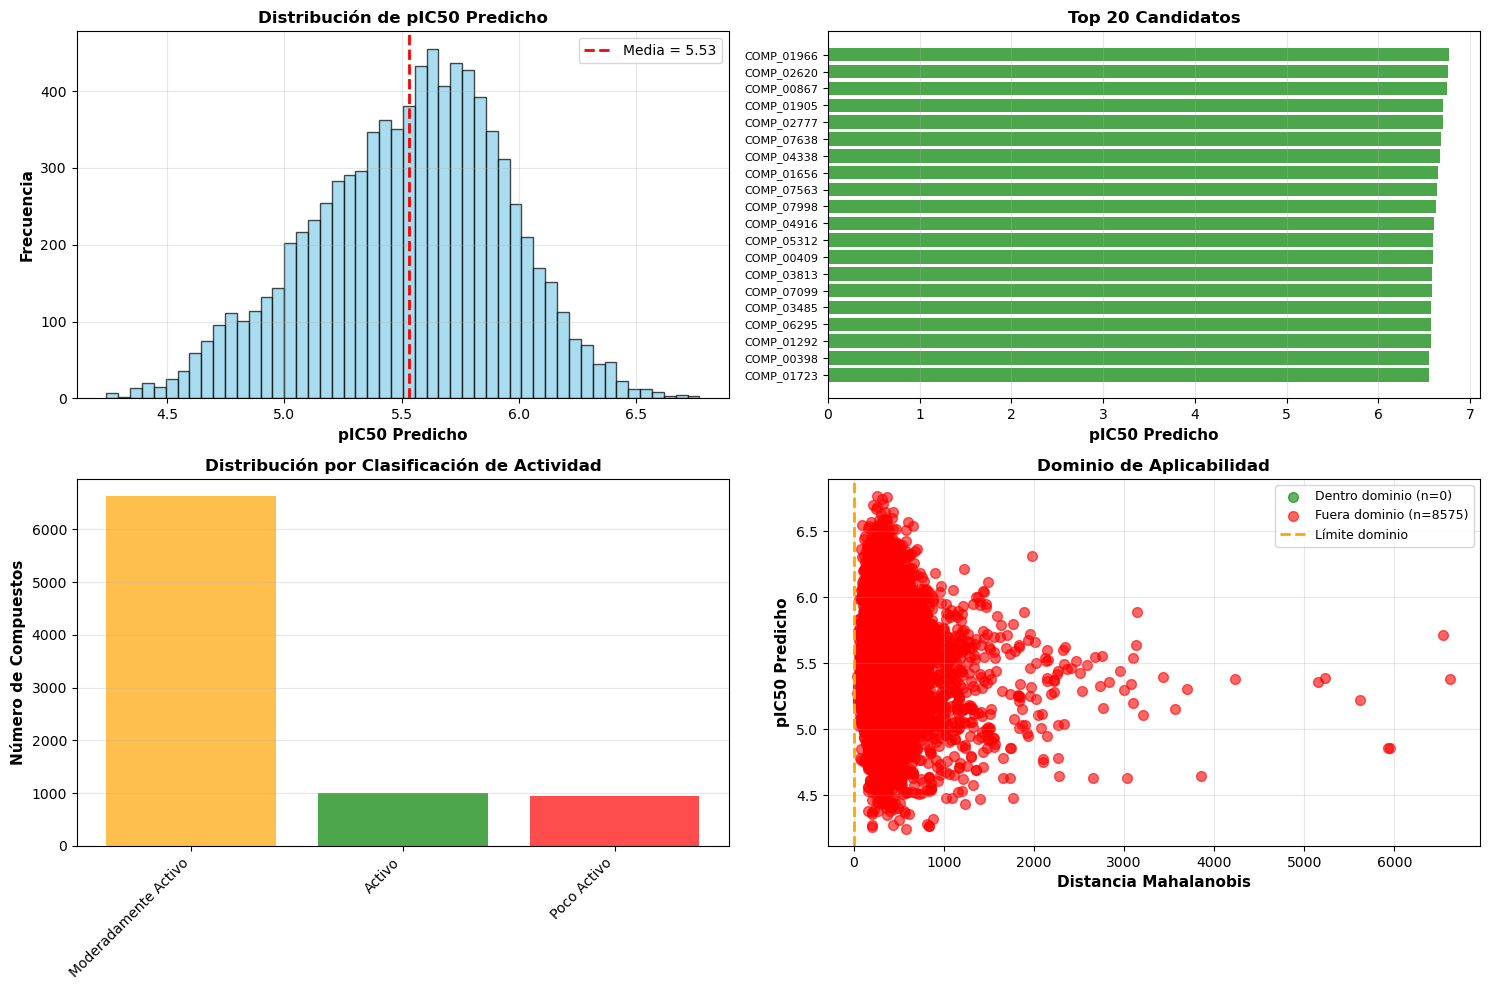

   ✓ Visualización guardada en: predicciones_nuevos_compuestos.png

✅ PREDICCIÓN COMPLETADA EXITOSAMENTE

FECHA Y HORA DE FINALIZACIÓN: 2025-12-09 16:53:32
DURACIÓN TOTAL DEL PROCESO: 0:00:10.885181


In [5]:
# ========================================
# SISTEMA DE PREDICCIÓN PARA NUEVOS COMPUESTOS
# ========================================

# Sistema de Predicción para Nuevos Compuestos

def cargar_modelo_completo(modelo_path, metadata_path, cov_path):
    """
    Cargar el modelo y todos los metadatos necesarios para predicción
    """
    # Cargar modelo
    modelo = xgb.XGBRegressor()
    modelo.load_model(modelo_path)
    
    # Cargar metadatos
    with open(metadata_path, 'r', encoding='utf-8') as f:
        metadatos = json.load(f)
    
    # Cargar matriz de covarianza
    with open(cov_path, 'r') as f:
        cov_data = json.load(f)
    
    return modelo, metadatos, cov_data


#def validar_dominio_aplicabilidad(X_nuevos, cov_data, h_critico, mahal_critico):
def validar_dominio_aplicabilidad(X_nuevos, cov_inv, centroid, h_critico, mahal_critico):
    """
    Valida si los nuevos compuestos están dentro del dominio de aplicabilidad
    """
    #centroid = np.array(cov_data['centroid'])
    #cov_inv = np.array(cov_data['cov_inv'])
    
    # Calcular distancia de Mahalanobis
    diff = X_nuevos - centroid
    mahal_dist = np.sqrt(np.sum((diff @ cov_inv) * diff, axis=1))
    
    # Clasificar compuestos
    dentro_dominio = mahal_dist < mahal_critico
    confianza = np.where(dentro_dominio, 'Alta', 'Baja')
    
    return mahal_dist, dentro_dominio, confianza


def predecir_nuevos_compuestos(
    archivo_nuevos_compuestos,
    modelo_path,
    metadata_path,
    cov_path,
    top_n=100,
    archivo_salida='ranking_compuestos.xlsx'
):
    """
    Predice pIC50 para nuevos compuestos y genera ranking
    
    Parámetros:
    -----------
    archivo_nuevos_compuestos : str
        Ruta al archivo Excel con los nuevos compuestos
    modelo_path : str
        Ruta al modelo guardado (.json)
    metadata_path : str
        Ruta a los metadatos (.json)
    cov_path : str
        Ruta a matriz de covarianza (.json)
    top_n : int
        Número de mejores candidatos a reportar
    archivo_salida : str
        Nombre del archivo Excel de salida
    """
    
    print("\n" + "="*80)
    print("SISTEMA DE PREDICCIÓN - NUEVOS COMPUESTOS")
    print("="*80)
    
    # 1. Cargar modelo y metadatos
    print("\n1. Cargando modelo y metadatos...")
    modelo, metadatos, cov_data = cargar_modelo_completo(
        modelo_path, metadata_path, cov_path
    )
    print(f"   ✓ Modelo cargado exitosamente")
    print(f"   ✓ Fecha entrenamiento: {metadatos['fecha_entrenamiento']}")
    print(f"   ✓ RMSE Test: {metadatos['metricas_test_limpias']['rmse']:.4f}")
    print(f"   ✓ R² Test: {metadatos['metricas_test_limpias']['r2']:.4f}")
    
    # 2. Cargar nuevos compuestos
    print("\n2. Cargando nuevos compuestos...")
    df_nuevos = pd.read_excel(archivo_nuevos_compuestos, sheet_name="Datos")
    print(f"   ✓ {len(df_nuevos)} compuestos cargados")
    print(f"Tamaño del dataset con descriptores de Drugbank: {df_nuevos.shape}")

    # 3. Preparar datos (asegurarse que tengan las mismas columnas)
    print("\n3. Preparando datos...")
    nombres_esperados = metadatos['nombres_predictoras']
    # Verificar que existan todas las columnas necesarias
    columnas_faltantes = set(nombres_esperados) - set(df_nuevos.columns)
    if columnas_faltantes:
        print(f"   ⚠️  ADVERTENCIA: Faltan columnas: {columnas_faltantes}")
        print("   Se rellenarán con ceros (puede afectar predicciones)")
        for col in columnas_faltantes:
            df_nuevos[col] = 0
    
    # Seleccionar y ordenar columnas en el orden correcto
    X_nuevos = df_nuevos[nombres_esperados].values
    print(f"   ✓ Matriz de predictores ordenados: {X_nuevos.shape}")
    X_nuevos_df = df_nuevos[nombres_esperados]
    X_nuevos_df.info()
    print("/n")
    X_nuevos_df.describe()
    
    # 4. Validar dominio de aplicabilidad
    print("\n4. Validando dominio de aplicabilidad...")
    cov_inv = np.load('matriz_covarianza.npy')
    centroid = np.load('centroide.npy')
    mahal_dist, dentro_dominio, confianza = validar_dominio_aplicabilidad(
        X_nuevos,
        #cov_data,
        cov_inv,
        centroid,
        metadatos['dominio_aplicabilidad']['h_critico'],
        metadatos['dominio_aplicabilidad']['mahal_critico']
    )
    
    n_dentro = np.sum(dentro_dominio)
    n_fuera = len(dentro_dominio) - n_dentro
    print(f"   ✓ Compuestos dentro del dominio: {n_dentro} ({100*n_dentro/len(dentro_dominio):.1f}%)")
    if n_fuera > 0:
        print(f"   ⚠️  Compuestos fuera del dominio: {n_fuera} ({100*n_fuera/len(dentro_dominio):.1f}%)")
        print(f"      Las predicciones para estos compuestos son menos confiables")
    
    # 5. Realizar predicciones
    print("\n5. Realizando predicciones...")
    predicciones_pIC50 = modelo.predict(X_nuevos)
    print(f"   ✓ Predicciones completadas")
    print(f"   - pIC50 mínimo: {predicciones_pIC50.min():.4f}")
    print(f"   - pIC50 máximo: {predicciones_pIC50.max():.4f}")
    print(f"   - pIC50 promedio: {predicciones_pIC50.mean():.4f}")
    
    # 6. Convertir pIC50 a IC50 (nM)
    # IC50 (nM) = 10^(9 - pIC50)
    predicciones_IC50 = 10**(9 - predicciones_pIC50)
    
    # 7. Crear DataFrame con resultados
    print("\n6. Generando resultados...")
    
    # Obtener identificadores si existen
    if 'molecule_chembl_id' in df_nuevos.columns:
        ids = df_nuevos['molecule_chembl_id'].values
    elif 'Compuesto_ID' in df_nuevos.columns:
        ids = df_nuevos['Compuesto_ID'].values
    else:
        ids = [f"COMP_{i+1:05d}" for i in range(len(df_nuevos))]
    
    df_resultados = pd.DataFrame({
        'Compuesto_ID': ids,
        'pIC50_Predicho': predicciones_pIC50,
        'IC50_Predicho_nM': predicciones_IC50,
        'Distancia_Mahalanobis': mahal_dist,
        'Dentro_Dominio': dentro_dominio,
        'Confianza_Prediccion': confianza
    })
    
    # Clasificar actividad según pIC50
    def clasificar_actividad(pic50):
        if pic50 >= 7:
            return 'Muy Activo'
        elif pic50 >= 6:
            return 'Activo'
        elif pic50 >= 5:
            return 'Moderadamente Activo'
        else:
            return 'Poco Activo'
    
    df_resultados['Clasificacion_Actividad'] = df_resultados['pIC50_Predicho'].apply(
        clasificar_actividad
    )
    
    # 8. Ordenar por pIC50 (mayor a menor = mejor actividad)
    df_resultados = df_resultados.sort_values('pIC50_Predicho', ascending=False)
    df_resultados['Ranking'] = range(1, len(df_resultados) + 1)
    
    # Reordenar columnas
    df_resultados = df_resultados[[
        'Ranking', 'Compuesto_ID', 'pIC50_Predicho', 'IC50_Predicho_nM',
        'Clasificacion_Actividad', 'Distancia_Mahalanobis',
        'Dentro_Dominio', 'Confianza_Prediccion'
    ]]
    
    # 9. Generar estadísticas
    print("\n7. Estadísticas generales:")
    print(f"   - Total compuestos analizados: {len(df_resultados)}")
    print(f"   - Muy Activos (pIC50 ≥ 7): {len(df_resultados[df_resultados['Clasificacion_Actividad']=='Muy Activo'])}")
    print(f"   - Activos (pIC50 ≥ 6): {len(df_resultados[df_resultados['Clasificacion_Actividad']=='Activo'])}")
    print(f"   - Moderadamente Activos (pIC50 ≥ 5): {len(df_resultados[df_resultados['Clasificacion_Actividad']=='Moderadamente Activo'])}")
    print(f"   - Poco Activos (pIC50 < 5): {len(df_resultados[df_resultados['Clasificacion_Actividad']=='Poco Activo'])}")
    
    # 10. Extraer top candidatos
    df_top = df_resultados.head(top_n)
    top_confiables = df_top[df_top['Dentro_Dominio'] == True]
    
    print(f"\n8. Top {top_n} candidatos:")
    print(f"   - Candidatos dentro del dominio: {len(top_confiables)}/{top_n}")
    print(f"   - Mejor pIC50: {df_top.iloc[0]['pIC50_Predicho']:.4f} (IC50 = {df_top.iloc[0]['IC50_Predicho_nM']:.2f} nM)")
    
    # 11. Guardar resultados
    print(f"\n9. Guardando resultados...")
    
    with pd.ExcelWriter(archivo_salida, engine='openpyxl') as writer:
        # Hoja 1: Top candidatos
        df_top.to_excel(writer, sheet_name=f'Top_{top_n}_Candidatos', index=False)
        
        # Hoja 2: Todos los resultados
        df_resultados.to_excel(writer, sheet_name='Todos_Resultados', index=False)
        
        # Hoja 3: Resumen estadístico
        resumen = pd.DataFrame({
            'Métrica': [
                'Total Compuestos',
                'Dentro del Dominio',
                'Fuera del Dominio',
                'Muy Activos (pIC50 ≥ 7)',
                'Activos (pIC50 ≥ 6)',
                'Moderadamente Activos (pIC50 ≥ 5)',
                'Poco Activos (pIC50 < 5)',
                'pIC50 Máximo',
                'pIC50 Promedio',
                'pIC50 Mínimo',
                'IC50 Mínimo (nM)',
                'RMSE Modelo',
                'R² Modelo'
            ],
            'Valor': [
                len(df_resultados),
                n_dentro,
                n_fuera,
                len(df_resultados[df_resultados['Clasificacion_Actividad']=='Muy Activo']),
                len(df_resultados[df_resultados['Clasificacion_Actividad']=='Activo']),
                len(df_resultados[df_resultados['Clasificacion_Actividad']=='Moderadamente Activo']),
                len(df_resultados[df_resultados['Clasificacion_Actividad']=='Poco Activo']),
                f"{predicciones_pIC50.max():.4f}",
                f"{predicciones_pIC50.mean():.4f}",
                f"{predicciones_pIC50.min():.4f}",
                f"{predicciones_IC50.min():.2f}",
                f"{metadatos['metricas_test']['rmse']:.4f}",
                f"{metadatos['metricas_test']['r2']:.4f}"
            ]
        })
        resumen.to_excel(writer, sheet_name='Resumen', index=False)
        
        # Hoja 4: Metadatos del modelo
        df_metadata = pd.DataFrame([metadatos['metricas_test']]).T
        df_metadata.to_excel(writer, sheet_name='Metadatos_Modelo')
    
    print(f"   ✓ Resultados guardados en: {archivo_salida}")
    
    # 12. Visualización rápida
    print("\n10. Generando visualización...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gráfica 1: Distribución de pIC50
    axes[0, 0].hist(predicciones_pIC50, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(predicciones_pIC50.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Media = {predicciones_pIC50.mean():.2f}')
    axes[0, 0].set_xlabel('pIC50 Predicho', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Distribución de pIC50 Predicho', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gráfica 2: Top 20 candidatos
    top_20 = df_resultados.head(20)
    axes[0, 1].barh(range(len(top_20)), top_20['pIC50_Predicho'].values, 
                    color='green', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top_20)))
    axes[0, 1].set_yticklabels(top_20['Compuesto_ID'].values, fontsize=8)
    axes[0, 1].invert_yaxis()
    axes[0, 1].set_xlabel('pIC50 Predicho', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Top 20 Candidatos', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # Gráfica 3: Distribución por clasificación
    clasificaciones = df_resultados['Clasificacion_Actividad'].value_counts()
    colores = {'Muy Activo': 'darkgreen', 'Activo': 'green', 
               'Moderadamente Activo': 'orange', 'Poco Activo': 'red'}
    axes[1, 0].bar(clasificaciones.index, clasificaciones.values, 
                   color=[colores[x] for x in clasificaciones.index], alpha=0.7)
    axes[1, 0].set_ylabel('Número de Compuestos', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Distribución por Clasificación de Actividad', 
                         fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Gráfica 4: Dominio de aplicabilidad
    dentro = df_resultados[df_resultados['Dentro_Dominio'] == True]
    fuera = df_resultados[df_resultados['Dentro_Dominio'] == False]
    
    axes[1, 1].scatter(dentro['Distancia_Mahalanobis'], dentro['pIC50_Predicho'],
                      alpha=0.6, s=50, color='green', label=f'Dentro dominio (n={len(dentro)})')
    axes[1, 1].scatter(fuera['Distancia_Mahalanobis'], fuera['pIC50_Predicho'],
                      alpha=0.6, s=50, color='red', label=f'Fuera dominio (n={len(fuera)})')
    axes[1, 1].axvline(metadatos['dominio_aplicabilidad']['mahal_critico'], 
                      color='orange', linestyle='--', linewidth=2, label='Límite dominio')
    axes[1, 1].set_xlabel('Distancia Mahalanobis', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('pIC50 Predicho', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Dominio de Aplicabilidad', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('predicciones_nuevos_compuestos.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✓ Visualización guardada en: predicciones_nuevos_compuestos.png")
    
    print("\n" + "="*80)
    print("✅ PREDICCIÓN COMPLETADA EXITOSAMENTE")
    print("="*80)
    
    return df_resultados, df_top

# ========================================
# EJEMPLO DE USO
# ========================================

# Después de entrenar el modelo, para predecir nuevos compuestos:

# Paso 1: Guardar el modelo.

# Paso 2: Para predecir nuevos compuestos Cargar el modelo entrenado.
df_resultados, df_top_100 = predecir_nuevos_compuestos(
    archivo_nuevos_compuestos='drugbank_compounds_descriptors_calculated.xlsx',  # Tu archivo con ~10000 compuestos
    modelo_path='modelo_xgboost_20251209_164939.json',   # El que se guardó
    metadata_path='metadatos_modelo_20251209_164939.json',
    cov_path='covarianza_dominio_20251209_164939.json',
    top_n=100,  # Top 100 mejores candidatos
    archivo_salida='ranking_top_100_candidatos.xlsx'
)

# Los resultados quedarán en 'ranking_top_100_candidatos.xlsx' con 4 hojas:
# 1. Top_100_Candidatos - Los 100 mejores
# 2. Todos_Resultados - Los 10000 compuestos rankeados
# 3. Resumen - Estadísticas generales
# 4. Metadatos_Modelo - Info del modelo usado

print("\n" + "="*80)
# Registrar tiempo de finalización y calcular duración total
fin_proceso = datetime.now()
duracion_total = fin_proceso - inicio_proceso

print(f"FECHA Y HORA DE FINALIZACIÓN: {fin_proceso.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"DURACIÓN TOTAL DEL PROCESO: {duracion_total}")